# Bitcoin Price Prediction Using LSTM Networks and Reddit Sentiment Analysis

### Alex Johnson, Malgy Blue, Emma Goodman
***

### Import Packages

In [29]:
import pandas as pd
import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.losses import binary_crossentropy

from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
from keras import optimizers

import seaborn as sns
from sklearn.metrics import mean_absolute_error

In [30]:
import plotly
from plotly import graph_objects as go
from plotly import express as px
from plotly.subplots import make_subplots

In [31]:
#!pip install transformers

from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import requests
from bs4 import BeautifulSoup
import re
from textblob import TextBlob

### Data Cleaning

In [243]:
bitcoin = pd.read_csv("./data/coin_Bitcoin.csv")
bitcoin.head()

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Bitcoin,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09
1,2,Bitcoin,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09
2,3,Bitcoin,BTC,2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09
3,4,Bitcoin,BTC,2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09
4,5,Bitcoin,BTC,2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09


In [244]:
# set date as index
bitcoin = bitcoin.set_index(['Date'])
# drop unnecessary columns
bitcoin = bitcoin.drop(['SNo', 'Name', 'Symbol'], 1)
# convert dates from string to datetime
bitcoin.index = pd.to_datetime(bitcoin.index)
# filter dates to align with sentiment data
bitcoin = bitcoin.loc[:'2019-12-31']
bitcoin.tail()

<ipython-input-244-33f94e369c6e>:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  bitcoin = bitcoin.drop(['SNo', 'Name', 'Symbol'], 1)


,High,Low,Open,Close,Volume,Marketcap
Date,,,,,,
2019-12-27 23:59:59,7363.529235,7189.933935,7238.141180,7290.088518,2.277736e+10,1.321395e+11
2019-12-28 23:59:59,7399.040889,7286.905172,7289.031130,7317.990034,2.136567e+10,1.326591e+11
2019-12-29 23:59:59,7513.948409,7279.865468,7317.647588,7422.652589,2.244526e+10,1.345708e+11
2019-12-30 23:59:59,7454.824027,7276.308140,7420.272788,7292.995078,2.287413e+10,1.322351e+11
2019-12-31 23:59:59,7335.290051,7169.777686,7294.438896,7193.598978,2.116795e+10,1.304461e+11


In [396]:
def show_history(coin_name):
    high = coin_name['High']
    low = coin_name['Low']
    open = coin_name['Open']
    close = coin_name['Close']
    fig = px.line(coin_name, x= coin_name.index, y =[high, low, open, close], labels={'Date': 'Date','value':'Price'})
    fig.update_layout(title_text= "Bitcoin History", font_size=15, font_color='Blue',legend_title_text='Parameters')
    fig.show()

In [400]:
show_history(bitcoin[-100:])

## LSTM

### Train/Test Split

In [246]:
target_col = "Close"

In [247]:
def train_test_split(df, test_size = 0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

train, test = train_test_split(bitcoin, test_size = 0.2)

In [248]:
print("Length train: ", len(train))
print("Length test: ", len(test))

Length train:  1951
Length test:  487


In [249]:
def line_plot(line1, line2, label1 = None, label2 = None, title = '', lw = 2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw, color = '#f2a900')
    ax.plot(line2, label=label2, linewidth=lw, color = '#4d4d4e')
    ax.set_ylabel('Price [USD]', fontsize=14)
    ax.set_title(title, fontsize=16, weight = 'bold')
    ax.legend(loc='best', fontsize=16)

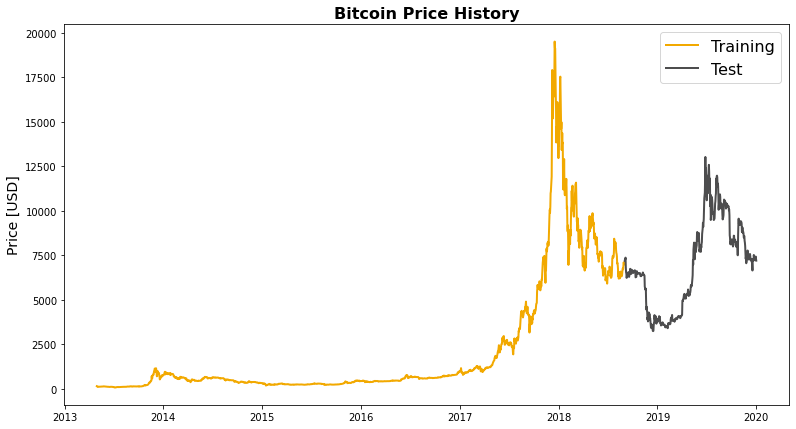

In [250]:
line_plot(train[target_col], test[target_col], 'Training', 'Test', title='Bitcoin Price History')

### Model Development

In [305]:
# normalization (changing numeric values to common scale)
# does not distort difference in the range of the values

normalize = ['High', 'Low', 'Open', 'Close', 'Marketcap']

def normalize_zero_base(df):
    return df[normalize] / df[normalize].iloc[0] - 1

In [306]:
# extract data in windows (number of previous days)

def extract_window_data(df, window_len = 5, zero_base = True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalize_zero_base(tmp)
        window_data.append(tmp.values)
        
    return np.array(window_data)

In [307]:
def prepare_data(df, target_col, window_len=5, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [308]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear', dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape =(input_data.shape[1],input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    
    return model

In [309]:
def window_model(windowsize = None):
    
    np.random.seed(42)
    window_len = windowsize
    test_size = 0.2
    zero_base = True
    lstm_neurons = 100
    epochs = 10
    batch_size = 32
    loss = 'mse'
    dropout = 0.2
    optimizer = "adam"
    
    train, test, X_train, X_test, y_train, y_test = prepare_data(
    bitcoin, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)
    
    model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
    history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)
    
    targets = test[target_col][window_len:]
    preds = model.predict(X_test).squeeze()
    return mean_absolute_error(preds, y_test)

### 5-Days Model

In [318]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 9
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = "adam"

In [319]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    bitcoin, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [320]:
X_train.shape

(1946, 5, 5)

In [321]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/9
61/61 [==============================] - 2s 4ms/step - loss: 0.0039
Epoch 2/9
61/61 [==============================] - 0s 3ms/step - loss: 0.0029
Epoch 3/9
61/61 [==============================] - 0s 4ms/step - loss: 0.0026
Epoch 4/9
61/61 [==============================] - 0s 3ms/step - loss: 0.0024
Epoch 5/9
61/61 [==============================] - 0s 3ms/step - loss: 0.0023
Epoch 6/9
61/61 [==============================] - 0s 3ms/step - loss: 0.0023
Epoch 7/9
61/61 [==============================] - 0s 3ms/step - loss: 0.0022
Epoch 8/9
61/61 [==============================] - 0s 3ms/step - loss: 0.0021
Epoch 9/9
61/61 [==============================] - 0s 3ms/step - loss: 0.0021


Text(0.5, 0, 'Epoch')

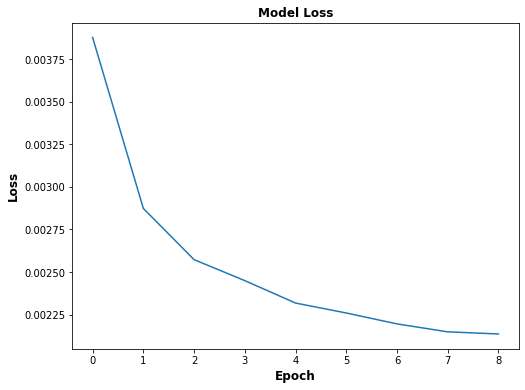

In [340]:
plt.figure(figsize = (8, 6))
plt.plot(history.history['loss'])
plt.title('Model Loss', weight = 'bold')
plt.ylabel('Loss', weight = 'bold', fontsize = 12)
plt.xlabel('Epoch', weight = 'bold', fontsize = 12)

In [323]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
print("Mean Absolute Error: ", mean_absolute_error(preds, y_test))

Mean Absolute Error:  0.023269480104875662


In [324]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)

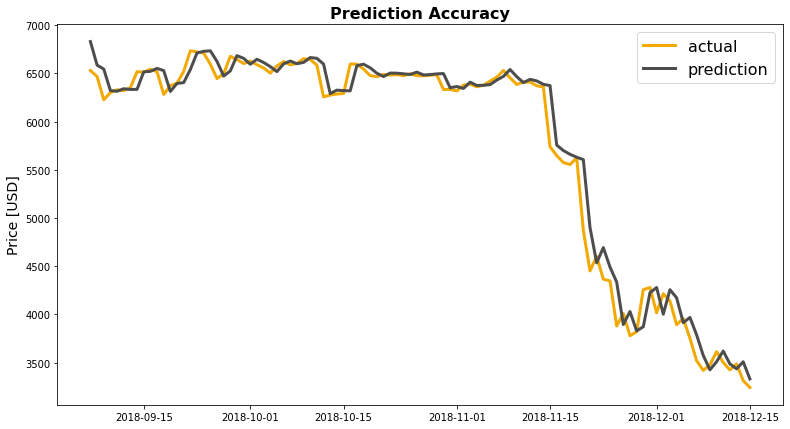

In [325]:
line_plot(targets[:100], preds[:100], 'actual', 'prediction', title = "Prediction Accuracy", lw=3)

### Compare MSE By Window Length

In [326]:
length = [5, 10, 15, 20, 30]

mse = []

for i in length:
    mse.append(window_model(i))

Epoch 1/10
61/61 [==============================] - 2s 3ms/step - loss: 0.0049
Epoch 2/10
61/61 [==============================] - 0s 3ms/step - loss: 0.0029
Epoch 3/10
61/61 [==============================] - 0s 3ms/step - loss: 0.0027
Epoch 4/10
61/61 [==============================] - 0s 3ms/step - loss: 0.0025
Epoch 5/10
61/61 [==============================] - 0s 3ms/step - loss: 0.0024
Epoch 6/10
61/61 [==============================] - 0s 3ms/step - loss: 0.0023
Epoch 7/10
61/61 [==============================] - 0s 3ms/step - loss: 0.0022
Epoch 8/10
61/61 [==============================] - 0s 3ms/step - loss: 0.0022
Epoch 9/10
61/61 [==============================] - 0s 3ms/step - loss: 0.0022
Epoch 10/10
61/61 [==============================] - 0s 3ms/step - loss: 0.0021
Epoch 1/10
61/61 [==============================] - 2s 5ms/step - loss: 0.0078
Epoch 2/10
61/61 [==============================] - 0s 5ms/step - loss: 0.0041
Epoch 3/10
61/61 [==============================] -

Text(0.5, 1.0, 'MSE vs. Window Length')

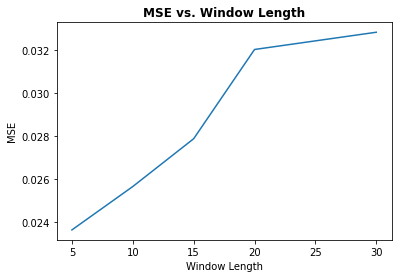

In [327]:
plt.plot(length, mse)
plt.ylabel("MSE")
plt.xlabel("Window Length")
plt.title("MSE vs. Window Length", weight = 'bold')

## Sentiment Analysis

In [6]:
reddit_bitcoin = pd.read_csv("./data/bitcoin_reddit_all.csv")

<ipython-input-6-ebff19d4ea4c>:1: DtypeWarning: Columns (0,1,2,3,4,8) have mixed types. Specify dtype option on import or set low_memory=False.
  reddit_bitcoin = pd.read_csv("./data/bitcoin_reddit_all.csv")


In [7]:
# remove nan date values
reddit_bitcoin = reddit_bitcoin[reddit_bitcoin['date'].notna()]
# remove unnecessary columns
reddit_bitcoin = reddit_bitcoin.drop(['Unnamed: 0', 'author', 'created_utc', 'controversiality'], 1)
# set date to index
reddit_bitcoin = reddit_bitcoin.set_index(['date'])
# convert date to datetime
reddit_bitcoin.index = pd.to_datetime(reddit_bitcoin.index)
reddit_bitcoin.head()

<ipython-input-7-be7bfd1c1818>:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  reddit_bitcoin = reddit_bitcoin.drop(['Unnamed: 0', 'author', 'created_utc', 'controversiality'], 1)


,datetime,subreddit,score,body
date,,,,
2014-06-26,2014-06-26 16:49:41,AskReddit,162.0,How do you feel about Bitcoin? I don't really ...
2014-05-17,2014-05-17 23:30:36,AskReddit,75.0,[The guy who blew a huge portion of his and hi...
2014-12-18,2014-12-18 04:54:48,Outdoors,-4.0,Because you are a damn liar.\n\nFrom my other ...
2014-04-30,2014-04-30 00:24:16,tf2,13.0,This was the bitcoin hat guy that ACTUALLY del...
2014-07-07,2014-07-07 16:06:21,starcraft,19.0,I'm sure this is *good* for bitcoin


In [8]:
def subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# function to ge the polarity
def polarity(text):
    return TextBlob(text).sentiment.polarity
def getAnalysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

In [10]:
def add_sentiment(df):    
    for i in range(len(df['body'])):
        if len(str(df['body'][i])) > 400:
            score = polarity(str(df['body'][i][:400]))
            df.iloc[i, 4] = score
        else:
            score = polarity(str(df['body'][i]))
            df.iloc[i, 4] = score
    return df

In [12]:
reddit_bitcoin["Sentiment Polarity"] = 0

add_sentiment(reddit_bitcoin)

,datetime,subreddit,score,body,Sentiment Polarity
date,,,,,
2014-06-26,2014-06-26 16:49:41,AskReddit,162.0,How do you feel about Bitcoin? I don't really ...,0.250000
2014-05-17,2014-05-17 23:30:36,AskReddit,75.0,[The guy who blew a huge portion of his and hi...,0.200000
2014-12-18,2014-12-18 04:54:48,Outdoors,-4.0,Because you are a damn liar.\n\nFrom my other ...,0.068750
2014-04-30,2014-04-30 00:24:16,tf2,13.0,This was the bitcoin hat guy that ACTUALLY del...,0.000000
2014-07-07,2014-07-07 16:06:21,starcraft,19.0,I'm sure this is *good* for bitcoin,0.600000
...,...,...,...,...,...
2019-03-16,2019-03-16 16:23:45,teslamotors,-1.0,Put 10% of those savings in Bitcoin.,0.000000
2019-03-20,2019-03-20 22:14:09,Bitcoin,-1.0,Litecoin is another shitcoin used for testing ...,0.000000
2019-03-23,2019-03-23 21:08:12,technology,-1.0,Hahahahaha Bitcoin dudes are such dumbasses,0.100000


In [21]:
reddit_bitcoin = reddit_bitcoin[['datetime', 'subreddit', 'body', 'Sentiment Polarity']]
reddit_bitcoin.head()

,datetime,subreddit,body,Sentiment Polarity
date,,,,
2014-06-26,2014-06-26 16:49:41,AskReddit,How do you feel about Bitcoin? I don't really ...,0.25000
2014-05-17,2014-05-17 23:30:36,AskReddit,[The guy who blew a huge portion of his and hi...,0.20000
2014-12-18,2014-12-18 04:54:48,Outdoors,Because you are a damn liar.\n\nFrom my other ...,0.06875
2014-04-30,2014-04-30 00:24:16,tf2,This was the bitcoin hat guy that ACTUALLY del...,0.00000
2014-07-07,2014-07-07 16:06:21,starcraft,I'm sure this is *good* for bitcoin,0.60000


In [94]:
daily_sentiment_mean = pd.DataFrame(reddit_bitcoin.groupby(reddit_bitcoin.index)['Sentiment Polarity'].mean())
daily_sentiment_mean.tail()

,Sentiment Polarity
date,
2019-12-27,0.095724
2019-12-28,0.096332
2019-12-29,0.085417
2019-12-30,0.096880
2019-12-31,0.092410


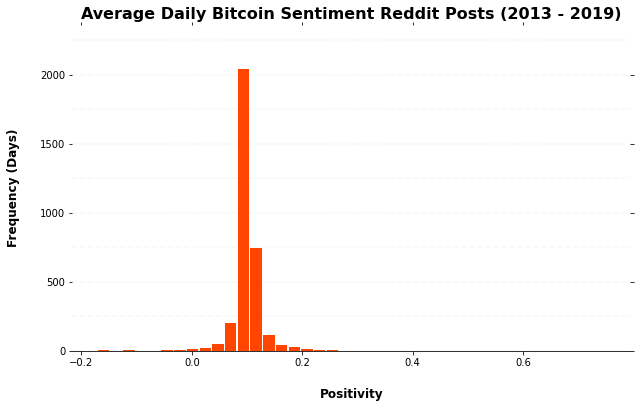

In [365]:
ax = daily_sentiment_mean.hist(column='Sentiment Polarity', bins=40, grid=False, figsize=(10,6), color='#FF4500', zorder=2, rwidth=0.9)

ax = ax[0]
for x in ax:

    # Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)

    # Switch off ticks
    x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # Remove title
    x.set_title("Average Daily Bitcoin Sentiment Reddit Posts (2013 - 2019)", weight = 'bold', size = 16)

    # Set x-axis label
    x.set_xlabel("Positivity", labelpad=20, weight='bold', size=12)

    # Set y-axis label
    x.set_ylabel("Frequency (Days)", labelpad=20, weight='bold', size=12)

In [362]:
reddit_bitcoin[reddit_bitcoin["Sentiment Polarity"] == reddit_bitcoin["Sentiment Polarity"].max()].iat[200,2]

"You'll be able to buy a house for 1 bitcoin in 5 years!!!!"

In [391]:
reddit_bitcoin[reddit_bitcoin["Sentiment Polarity"] == reddit_bitcoin["Sentiment Polarity"].max()].iat[7,2]

"Nobody owns bitcoin, and Satoshi's opinion is squat at this point, although he is freaking awesome"

In [304]:
reddit_bitcoin[reddit_bitcoin["Sentiment Polarity"] == reddit_bitcoin["Sentiment Polarity"].min()].iat[0, 2]

"I hate bitcoin. It's controlled by illuminati! "

## LSTM w/ Mean Sentiment 

In [378]:
bitcoin.index = bitcoin.index.date
bitcoin.head()

,High,Low,Open,Close,Volume,Marketcap
2013-04-29,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09
2013-04-30,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09
2013-05-01,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09
2013-05-02,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09
2013-05-03,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09


In [380]:
bitcoin_sentiment = bitcoin.merge(daily_sentiment_mean, left_index = True, right_index = True)
bitcoin_sentiment.tail()

,High,Low,Open,Close,Volume,Marketcap,Sentiment Polarity
2019-12-27,7363.529235,7189.933935,7238.141180,7290.088518,2.277736e+10,1.321395e+11,0.095724
2019-12-28,7399.040889,7286.905172,7289.031130,7317.990034,2.136567e+10,1.326591e+11,0.096332
2019-12-29,7513.948409,7279.865468,7317.647588,7422.652589,2.244526e+10,1.345708e+11,0.085417
2019-12-30,7454.824027,7276.308140,7420.272788,7292.995078,2.287413e+10,1.322351e+11,0.096880
2019-12-31,7335.290051,7169.777686,7294.438896,7193.598978,2.116795e+10,1.304461e+11,0.092410


In [381]:
normalize = ['High', 'Low', 'Open', 'Close', 'Marketcap', 'Sentiment Polarity']

np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 9
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = "adam"

In [383]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    bitcoin_sentiment, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [384]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/9
61/61 [==============================] - 2s 3ms/step - loss: 0.0049
Epoch 2/9
61/61 [==============================] - 0s 3ms/step - loss: 0.0031
Epoch 3/9
61/61 [==============================] - 0s 3ms/step - loss: 0.0029
Epoch 4/9
61/61 [==============================] - 0s 3ms/step - loss: 0.0026
Epoch 5/9
61/61 [==============================] - 0s 3ms/step - loss: 0.0027
Epoch 6/9
61/61 [==============================] - 0s 3ms/step - loss: 0.0026
Epoch 7/9
61/61 [==============================] - 0s 4ms/step - loss: 0.0023
Epoch 8/9
61/61 [==============================] - 0s 3ms/step - loss: 0.0023
Epoch 9/9
61/61 [==============================] - 0s 3ms/step - loss: 0.0023


Text(0.5, 0, 'Epoch')

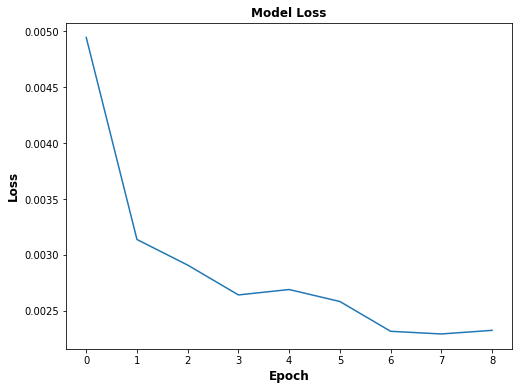

In [388]:
plt.figure(figsize = (8, 6))
plt.plot(history.history['loss'])
plt.title('Model Loss', weight = 'bold')
plt.ylabel('Loss', weight = 'bold', fontsize = 12)
plt.xlabel('Epoch', weight = 'bold', fontsize = 12)

In [386]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
print("Mean Absolute Error: ", mean_absolute_error(preds, y_test))

Mean Absolute Error:  0.024791421806496225
